# Problem Statement

For companies to become competitive and increase their growth, they need to take advantage of what Artificial Intelligence and Machine Learning can bring to develop predictive models based on forecasting sales in the future.

Predictive models attempt to forecast these sales based on historical data, while taking into account the effects of seasonality, demand, holidays, promotions, and competition.

For this case study, the company requesting to create a prediction model, it has provided data from the sales department of 1,115 stores.

Sales related dataset:

* Id: transaction ID (combination of store and date)
* Store: unique identifier of the store
* Sales: daily sales, this is the target variable
* Customers: number of customers on a given day
* Open: Boolean to indicate if the store was open or closed (0 = closed, 1 = open)
* Promo: Describes if the store had any type of promotion that day or not
* StateHoliday: indicates if the day was a holiday or not (a = public holidays, b = Easter holidays, c = Christmas, 0 = It was not a holiday)
* SchoolHoliday - Indicates whether (Store, Date) is affected by public school closures

Dataset related to stores:

* StoreType: category indicating the type of store (a, b, c, d)
* Assortment: a = basic, b = extra, c = extended
* CompetitionDistance (in meters): distance to the nearest competition store
* CompetitionOpenSince [Month/Year]: date the competition opened
* Promo2: Promo2 is a continuous and consecutive promotion in some stores (0 = the store does not participate, 1 = the store participates)
* Promo2Since [Year/Week]: date on which the store starts participating in Promo2
* PromoInterval: describes the consecutive intervals where Promo2 begins, indicating the months in which it begins. p.e. "Feb,May,Aug,Nov" means that each new round of promotion starts in February, May, August, November of any year of that store

Original data source: https://www.kaggle.com/c/rossmann-store-sales/data

# Importing Libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')

import datetime

**Sales Dataset**

In [2]:
sales_train_df = pd.read_csv('train.csv', low_memory=False)
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [3]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


Some points:

* More than a million observations.
* No null data appears.
* Columns with dates are in Object format so it is necessary to change them to datetime.

In [4]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


* Average sales amount per day = 5773 euros, minimum sales per day = 0 euros, maximum sales per day = 41551 euros.
* Average number of clients = 633, minimum number of clients = 0, maximum number of clients = 7388.

**Stores dataset**

In [6]:
stores_df = pd.read_csv('store.csv')
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Points to mark:

* The total number of stores is 1115.
* There are null data which need to be treated.

In [8]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


* The average distance to a competitor's store is 5,404 m.
* There are stores that do not apply promotions, so the columns related to the date of application would be Nan. It is necessary to work with it.

# Exploratory data analysis

## Sales Dataset

**Null Data**

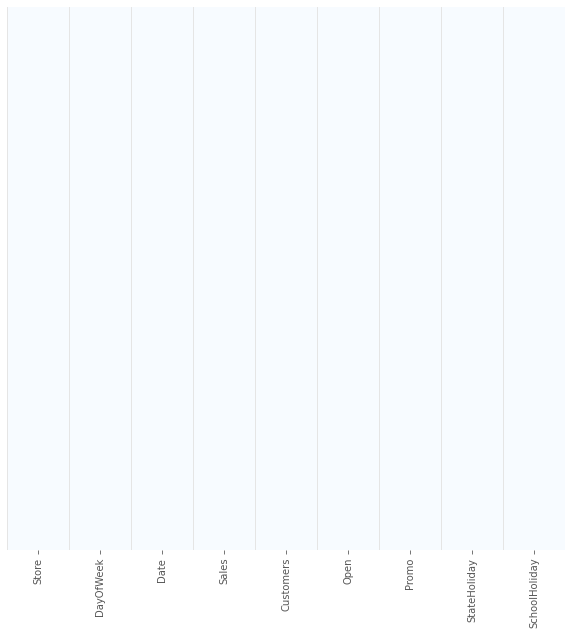

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(sales_train_df.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

In the sales dataset we do not have null data

**Distribution of variables**

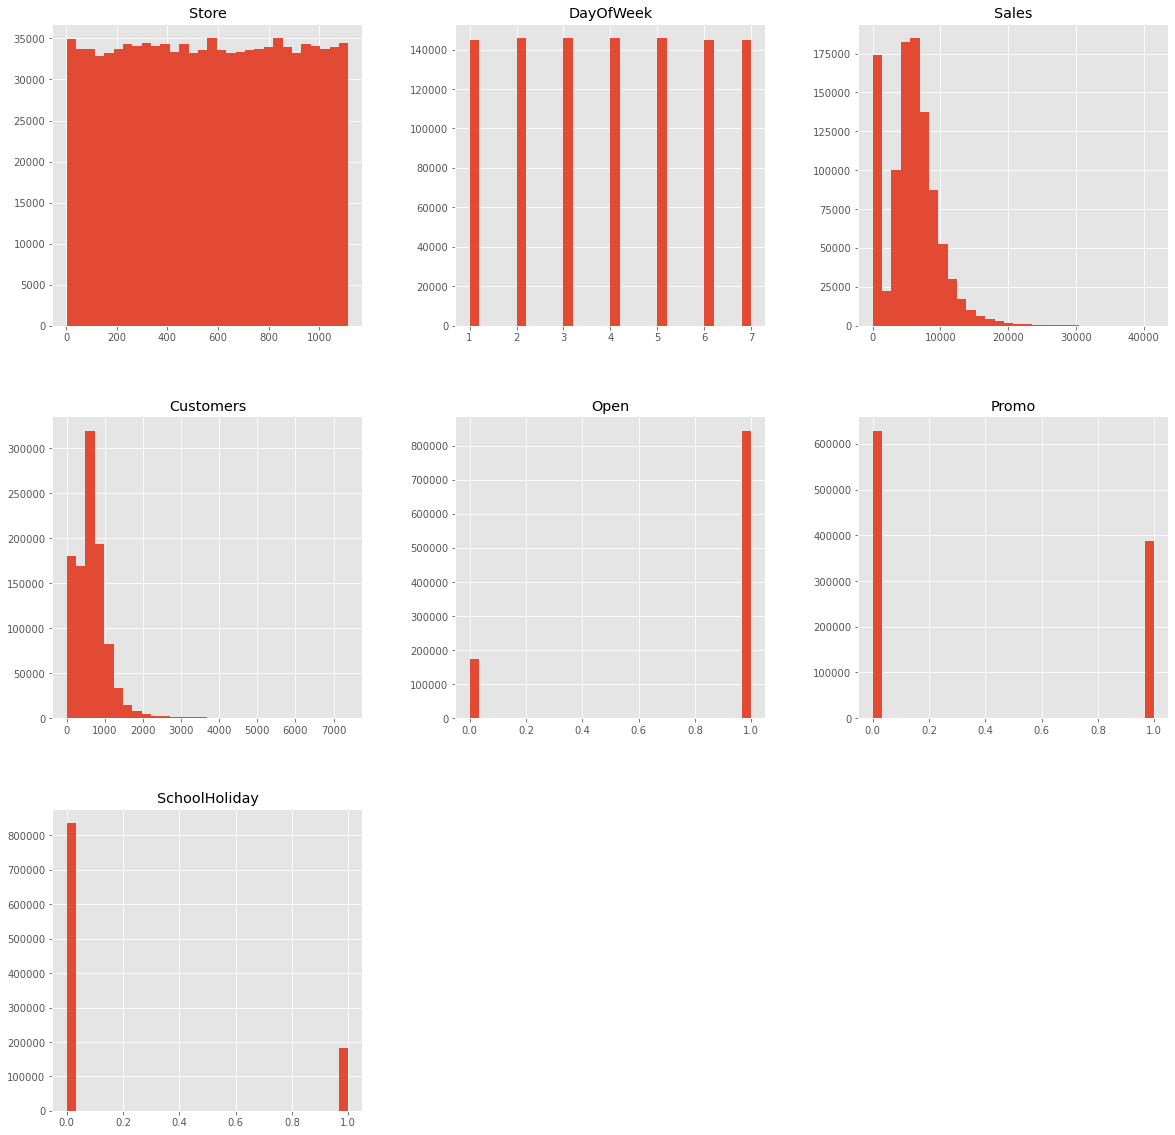

In [9]:
sales_train_df.hist(bins=30, figsize=(20,20))
plt.show()

Some important points to note with the histograms painted above:

* Average of 600 customers per day.
* Data is equally distributed across multiple days of the week (~150,000 observations x 7 days = ~1.1 million observations).
* Stores are open ~80% of the time
* Data is equally distributed across all stores (no bias).
* Promotion #1 ran approximately 40% of the time.
* Average sales around 5000-6000 euros
* School holidays last about 18% of the time.

**Analyzing vacation days**

When a store is closed, logically the billing on that day is $0 euros, so, for the model to be applied, this data is irrelevant.

But, because the store decides to close on a certain day. There is a possibility that stores close on the same days where there are school holidays.

In [10]:
sales_train_df_open = sales_train_df[sales_train_df['Open'] == 1]
sales_train_df_close = sales_train_df[sales_train_df['Open'] == 0]

print('Open: {} days, Close: {} days'.format(len(sales_train_df_open), len(sales_train_df_close)))
print('Close days percentage: {}%'.format(round((len(sales_train_df_close)/len(sales_train_df)*100),2)))

Open: 844392 days, Close: 172817 days
Close days percentage: 16.99%


With this data, we are left only with the days when the stores are open. The goal of the algorithm will be to predict the total bill on a given day, so if the store is closed, its bill is zero.

In [11]:
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

Now that we are left with only the days when the store is open, the open column no longer makes sense, so it is removed.

In [12]:
sales_train_df.drop(['Open'], axis=1, inplace=True)
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [13]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


Some stats have changed due to Open column has been removed:

* Average sales = 6955 euros (has increased).
* Average number of clients = 762 (has gone up).

## Stores dataset

**Null data**

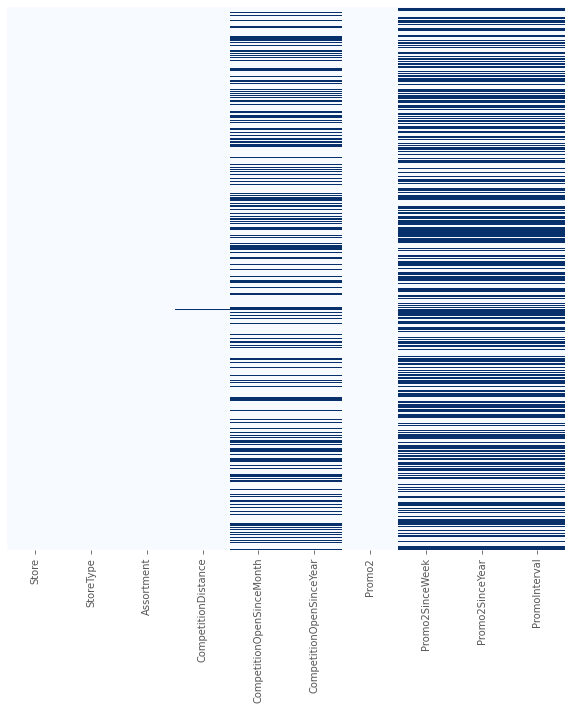

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(stores_df.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

Compared to the other dataset, in this one we do have null data, so we have to infer how to fill them or if we are going to eliminate them.

**Competition Distance**

In [15]:
stores_df[stores_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Only three stores are missing competitor distance.

**Competition Open Since Month**

In [16]:
stores_df[stores_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In this column we have 354 null data.

**Competition Open Since Year**

In [ ]:
stores_df[stores_df['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Like Competition Open Since Month, Competition Open Since Year has 354 null data. Possibly the same rows as Competition Open Since Month.

**Promo 2**

We have something to analyze, in the Promo2 columns where there is null data, the most likely is because the stores do not apply Promo2, so there is no information on Promo2 Since Week, Promo2 Since Year and PromoInterval.

In [ ]:
stores_df[stores_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


Where Promo2 is 0, that is, the store does not apply the promotion, the last three columns have no information.

Now that we are clear about the reason for the null values, it is time to decide what to do with them.

In this case, we cannot proceed to simply eliminate them, this is because the amount is high and we would only be left with little data.

What will be done is change all null data to 0.

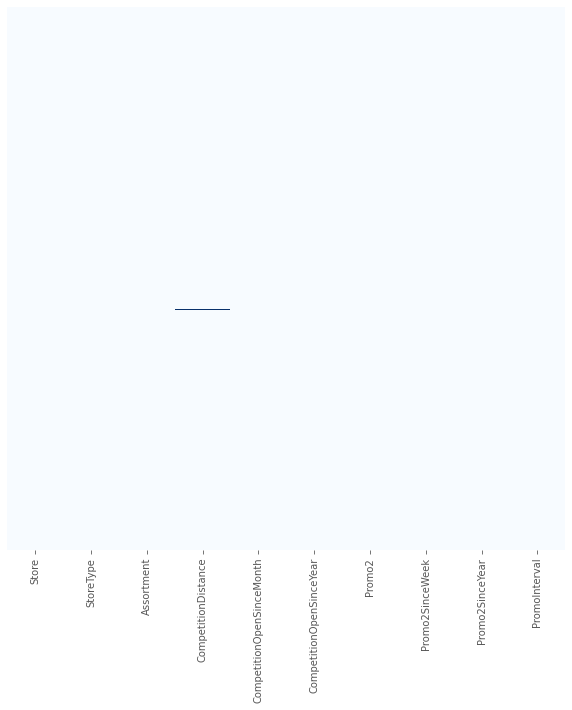

In [17]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear']

for col in str_cols:
    stores_df[col].fillna(0, inplace=True)

plt.figure(figsize=(10,10))
sns.heatmap(stores_df.isnull(), yticklabels=False, cbar=False, cmap='Blues')
plt.show()

We have worked with most of the null data, only the Competition Distance remains.

We are going to work with these data differently, we cannot place a distance of 0, because by common sense there is no competitor with a distance of 0.

In this case we are going to fill them with the average of the column.

In [18]:
stores_df['CompetitionDistance'].fillna(stores_df['CompetitionDistance'].mean(), inplace=True)

We make sure that we really don't have null data anymore.

In [19]:
stores_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

**Distribución de las variables**

Now that we no longer have nulls we will draw a histogram of each variable to visualize the distribution.

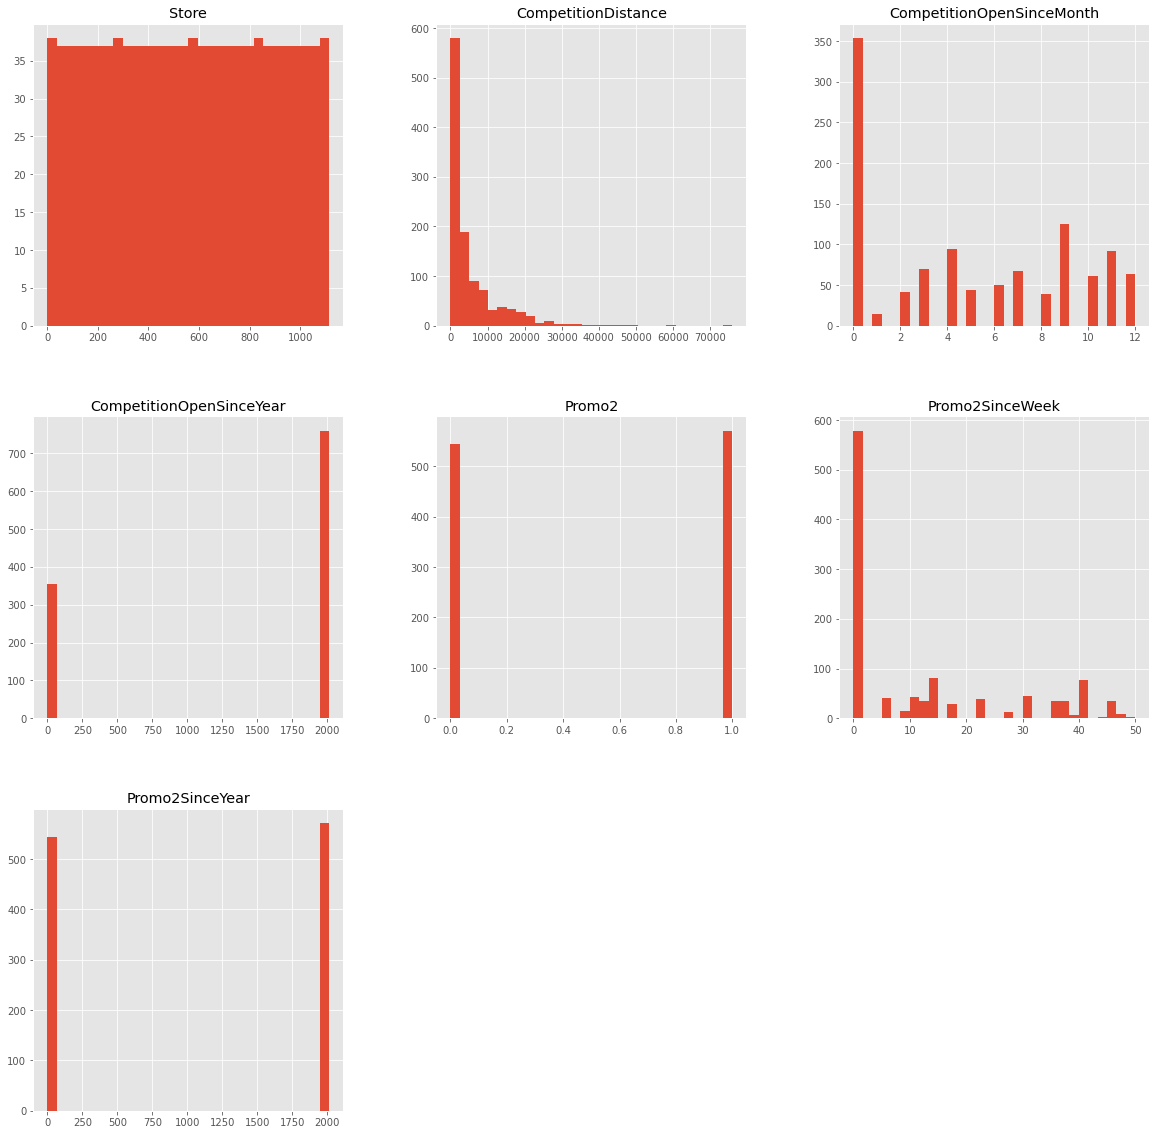

In [20]:
stores_df.hist(bins=30, figsize=(20,20))
plt.show()

* Half of the stores participate in promotion 2.
* Half of the stores have their competition at a distance of 0-3000 m (3 km away).

## Combined dataset.

Now that we have both datasets clean, it is time to combine them, both datasets share information regarding the store ID, so we will proceed to do a merge with respect to that column

In [21]:
sales_train_all_df = pd.merge(sales_train_df, stores_df, how='inner', on='Store')
sales_train_all_df.shape

(844392, 17)

We are left with a dataframe with 17 columns and 844392 data.

We will proceed to save this dataframe.

In [23]:
sales_train_all_df.to_csv('test.csv', index=False)

From now on, we will work with this saved dataset.

In [24]:
sales_train_all_df = pd.read_csv('test.csv')
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


**Correlation between variables**

In [25]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

* Customers and promotion are positively correlated with sales.
* Promo2 doesn't seem to be effective at all. It is negatively correlated with sales.
* The Promo, which are promotions applied in just one day, if it seems to have a positive correlation, so the sales turnover increases.

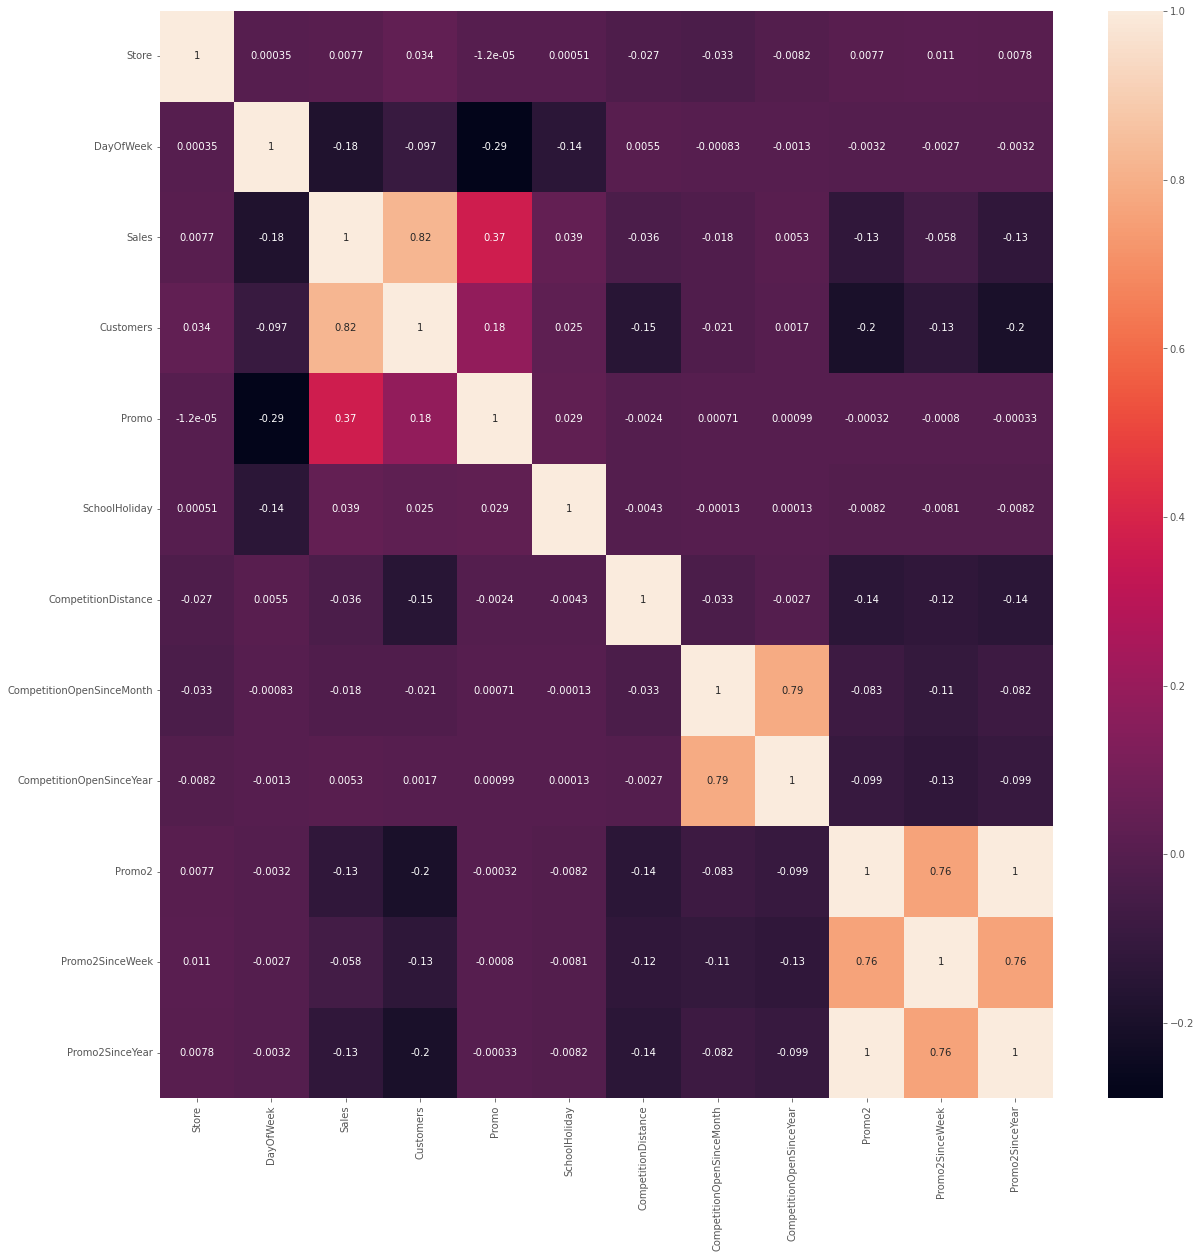

In [26]:
correlations_all = sales_train_all_df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlations_all, annot=True)
plt.show()

Analyzing the correlation graph we find:

* A correlation between Promo2 and Promo2 Since Year and Week. This does not contribute anything, because in practice if there is Promo 2, the other two fields exist in the same proportion.

* The same goes for Competition Open Since (Year and Month).

* Where if there is a correlation, it is in the variables already analyzed above, that of Promo with Sales and that of Customers with Sales.

**Working with dates**

The date column is in full format, so we'll add a column for the day, month, and year.

This will also help us when modeling the time series algorithm to predict sales.

In [27]:
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month 
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day 

sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


**Analyzing sales over time**

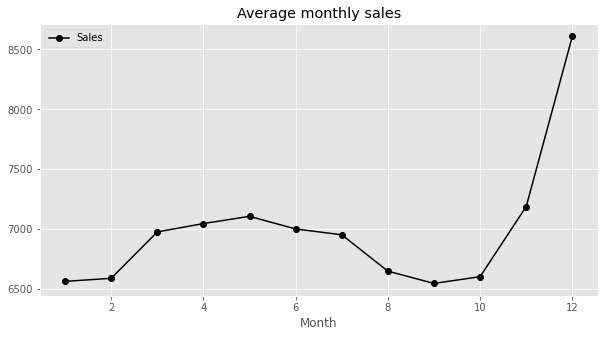

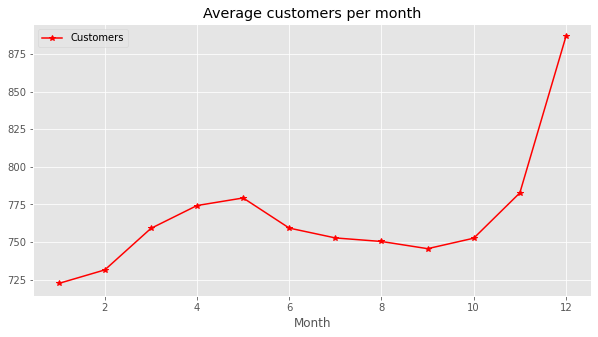

In [28]:
# Average monthly sales
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize=(10,5),
                                                                  marker='o', color='k')
plt.title('Average monthly sales')

# Average customers per month
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize=(10,5),
                                                                  marker='*', color='r')
plt.title('Average customers per month')
plt.show()

The sales graph is clear and we can conclude as follows:

* At the beginning of the year sales are low, this could be due to the January slope.
* As the year progresses, sales increase, this until month 7.
* After month 7 and until month 10, we see the downward trend. This may be due to customers saving for the holidays.
* As of month 10, sales increase exponentially, these two months are where the largest amount is recorded.

The second graph shows the correlation between the variable Clients and Sales.

We see the same trend in both.

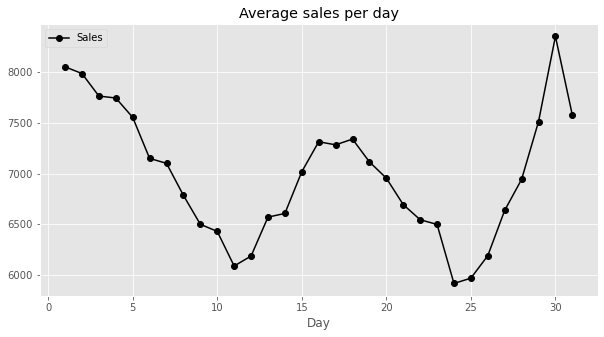

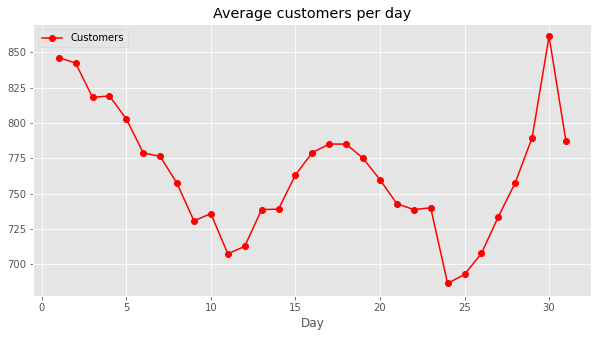

In [29]:
# Average sales per day
axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize=(10,5),
                                                                  marker='o', color='k')
plt.title('Average sales per day')

# Average customers per day
axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize=(10,5),
                                                                  marker='o', color='r')
plt.title('Average customers per day')
plt.show()

We can see something interesting in this graph.

* The sales trend seems to be correlated with the fortnightly payment of customers, At the end-beginning of the month, sales are high. In the same way in the middle of the month (day 15). But the weeks in between, sales go down.

Regarding customers (Second graph) we see the same trend. 

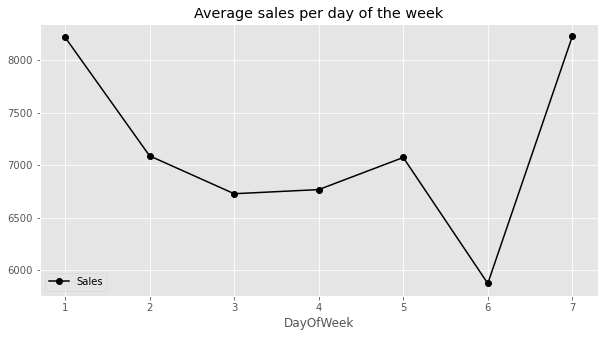

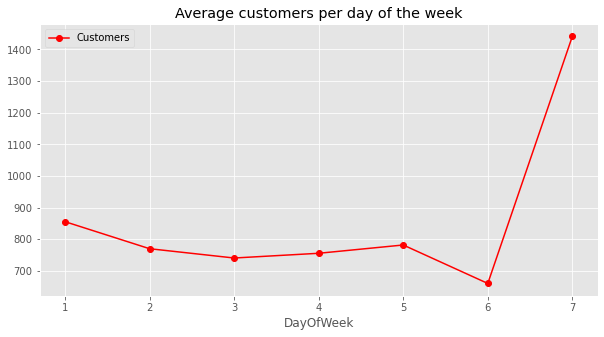

In [30]:
# Average sales per day of the week
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize=(10,5),
                                                                  marker='o', color='k')
plt.title('Average sales per day of the week')

# Average customers per day of the week
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize=(10,5),
                                                                  marker='o', color='r')
plt.title('Average customers per day of the week')
plt.show()

It is clearly seen that the greatest activity is observed on the last day of the week.

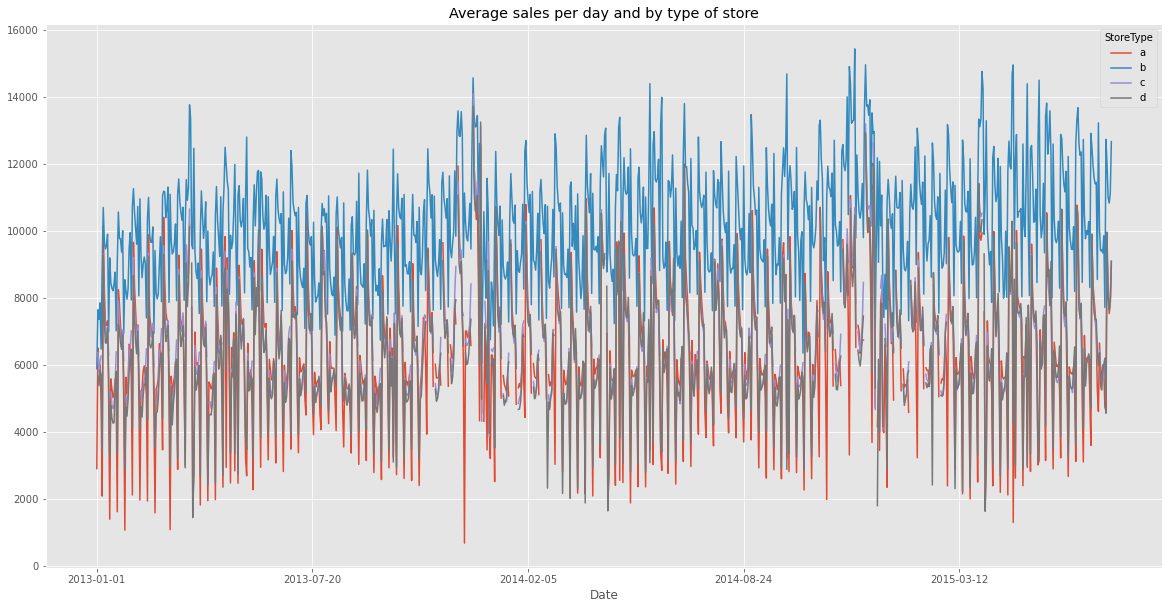

In [31]:
# Checking sales by store type
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax=ax)
plt.title('Average sales per day and by type of store')
plt.show()

The store of type b is the one that registers the highest amount of sales

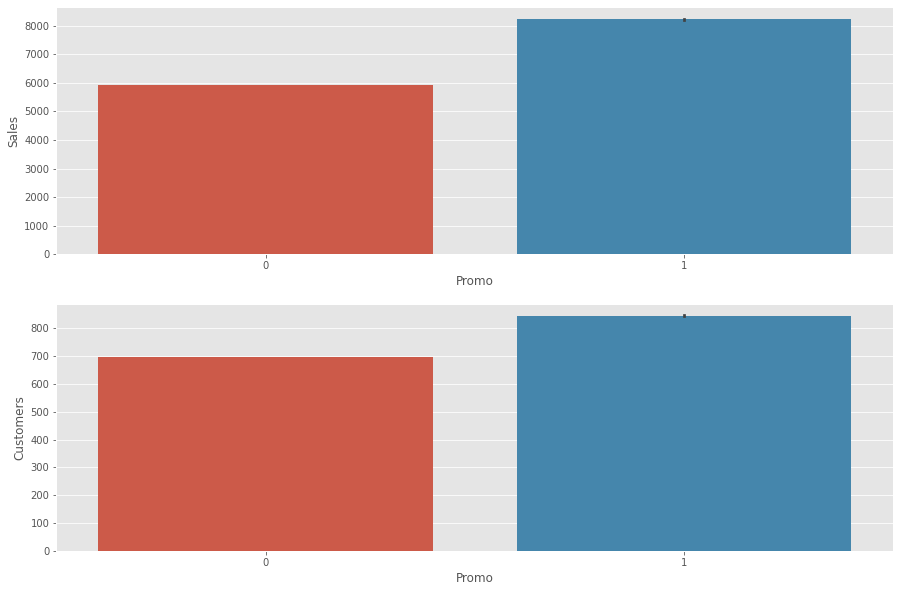

In [ ]:
plt.figure(figsize=[15,10])
plt.subplot(211)
sns.barplot(x='Promo', y='Sales', data=sales_train_all_df)

plt.subplot(212)
sns.barplot(x='Promo', y='Customers', data=sales_train_all_df)

plt.show()

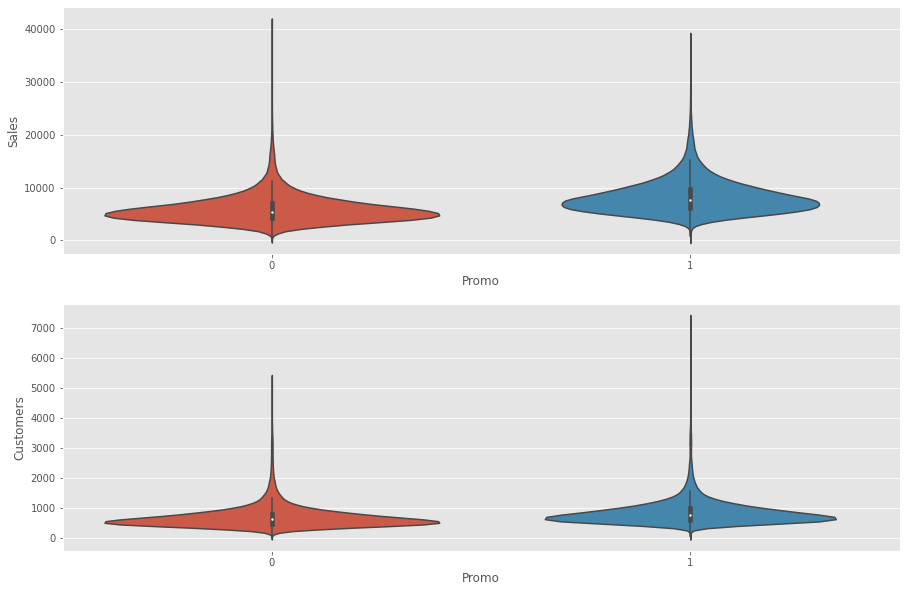

In [ ]:
plt.figure(figsize=[15,10])
plt.subplot(211)
sns.violinplot(x='Promo', y='Sales', data=sales_train_all_df)

plt.subplot(212)
sns.violinplot(x='Promo', y='Customers', data=sales_train_all_df)

plt.show()

When there is a promo, you clearly see an increase in sales and customers.

# Model Training

For this case study we will use a library called Fecebook Profhet, this library is specialized in time series models, so it is the best tool that can be used to predict sales.

In [70]:
from fbprophet import Prophet

The Facebook Prophet algorithm requires that the columns that will be subject to the model be renamed to $ds$, those related to dates, and $y$, to the variable to be predicted.

In [71]:
def sales_predictions(store_id, sales_df, period):
    sales_df = sales_df[sales_df['Store'] == store_id]
    sales_df = sales_df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    sales_df = sales_df.sort_values('ds')

    model = Prophet(daily_seasonality=False)
    model.fit(sales_df)

    future = model.make_future_dataframe(periods=period)
    forecast = model.predict(future)

    figure = model.plot(forecast, xlabel='Date', ylabel='Sales')
    figure2 = model.plot_components(forecast)

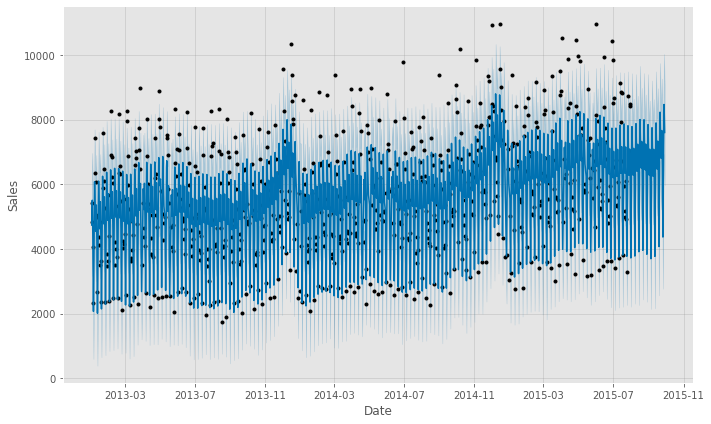

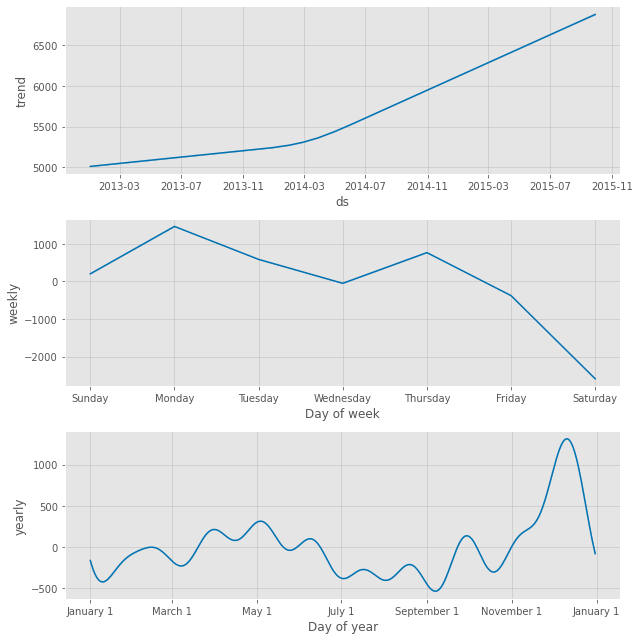

In [72]:
df = sales_predictions(8, sales_train_all_df, 60)

Once the algorithm has been applied to a certain store, we can obtain the graphs that help make decisions:

* The first graph: The points are the actual data, the blue lines are the predictions given by confidence intervals, where, the clearer the line, the more likely it is that the total sales on that day fall within the interval. In the final part of the graph we do not have black points. This is the prediction period that the algorithm makes us, that is, it predicts what may happen in the future, given the period that the user requires.

* The second graph shows the trend: In this store the trend is positive, which means that sales have increased over time.

* The third and fourth graphs also show a trend. This trend is related to sales per month and per week, how each month and each day behaves respectively.

## Adding the vacation variable

In [73]:
def sales_predictions(store_id, sales_df, holidays, period):
    sales_df = sales_df[sales_df['Store'] == store_id]
    sales_df = sales_df[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    sales_df = sales_df.sort_values('ds')

    model = Prophet(holidays=holidays, daily_seasonality=False)
    with suppress_stdout_stderr():
        model.fit(sales_df)

    future = model.make_future_dataframe(periods=period)
    forecast = model.predict(future)

    figure = model.plot(forecast, xlabel='Date', ylabel='Sales')
    figure2 = model.plot_components(forecast)

In our dataset we have two variables related to vacations:

* StateHolidays: Indicate if a day is a holiday or not:
   - a: public holidays.
   - b: Easter holidays.
   - c: Christmas holidays.
   - d: It is not a holiday

* ShoolHoliday: Indicates if the store is affected by school closures.

In [58]:
# We are left with dates where stores are affected by holidays
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1] \
  .loc[:, 'Date'].values

school_holidays.shape

(163457,)

In [59]:
# We are left only with the unique dates
school_holidays = np.unique(school_holidays)

In [45]:
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a') | 
                                    (sales_train_all_df['StateHoliday'] == 'b') |
                                    (sales_train_all_df['StateHoliday'] == 'c') |
                                    (sales_train_all_df['StateHoliday'] == 'd')] \
  .loc[:, 'Date'].values

state_holidays.shape

(910,)

In [46]:
# We are left only with the unique dates
state_holidays = np.unique(state_holidays)

We create the respective dataset for each type of vacation.

In [47]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                                'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2013-01-01,school_holiday
1,2013-01-02,school_holiday
2,2013-01-03,school_holiday
3,2013-01-04,school_holiday
4,2013-01-05,school_holiday
...,...,...
472,2015-07-27,school_holiday
473,2015-07-28,school_holiday
474,2015-07-29,school_holiday
475,2015-07-30,school_holiday


In [48]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                                'holiday': 'state_holiday'})
state_holidays.head()

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-06,state_holiday
2,2013-03-29,state_holiday
3,2013-04-01,state_holiday
4,2013-05-01,state_holiday


In [49]:
school_state_holidays = pd.concat((state_holidays, school_holidays), axis=0)

Since we have the vacation dataset, we proceed to train a model that takes this data into account.

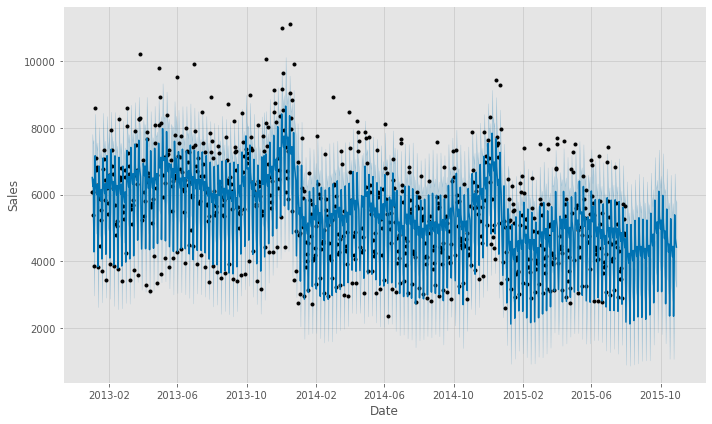

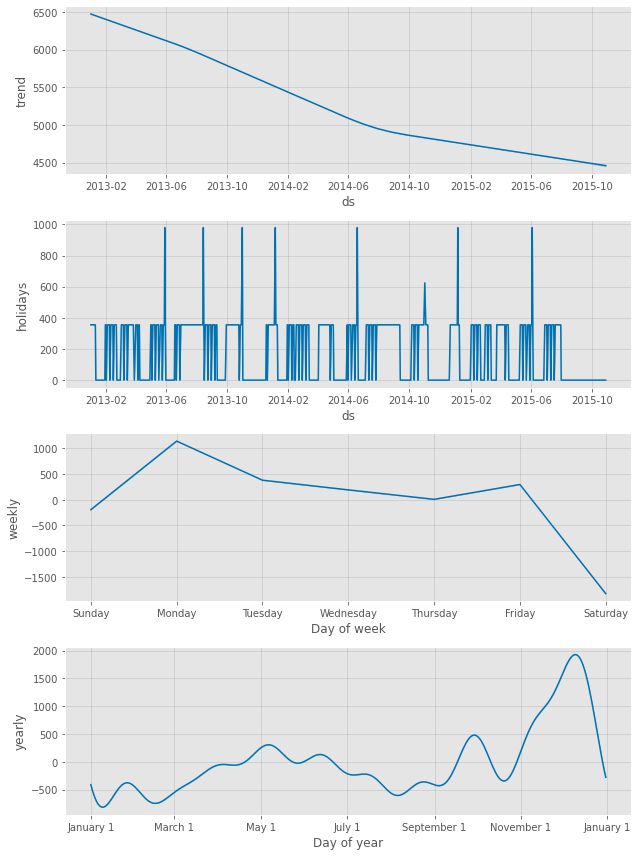

In [74]:
sales_predictions(6, sales_train_all_df, school_state_holidays, 90)

Now we have an extra graph.

* The holidays graph shows us how sales behave related to the holiday day, some days sales are zero, that is, the store closes, other days there are sales peaks of more than $1000 euros.